In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from itertools import cycle
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, OPTICS, cluster_optics_dbscan
sns.set_style('darkgrid')

from gensim.models.keyedvectors import KeyedVectors
# Read code vectors
DATASET_NAME = "python_dataset"
MODEL_NAME = "python_model"
token_embeddings = f'./data/{DATASET_NAME}/tokens.txt'
target_embeddings = f'./data/{DATASET_NAME}/targets.txt'

# Load code vectors and labels
vectors = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.vectors', sep=" ", header=None)
labels = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v', sep=" ").iloc[:, 0]

# Merge
df = vectors.assign(label=labels)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,label
0,-0.599106,-0.494233,0.658197,-0.836111,0.281650,-0.138599,0.180925,-0.809069,0.444631,-0.149288,...,-0.796595,0.389606,-0.334411,-0.758684,0.171675,0.399067,-0.081200,-0.980212,0.152141,error
1,-0.705933,-0.732547,0.297323,-0.869920,0.708338,0.239684,-0.874732,-0.987812,0.681524,0.048850,...,-0.437720,0.758881,0.158459,-0.971613,0.552959,0.184148,0.728983,-0.915237,0.486100,progress
2,-0.548934,-0.205947,-0.549685,0.627898,0.424189,-0.188388,0.773667,-0.780632,0.781880,0.135678,...,-0.915389,-0.224082,0.151841,-0.493800,0.842226,0.167514,-0.097905,-0.012163,0.153537,download
3,-0.500565,0.057152,-0.015398,-0.218637,0.393207,-0.159925,-0.630528,0.351062,-0.840472,-0.529884,...,-0.632701,-0.342118,0.112309,0.035547,0.841384,-0.794739,-0.429093,0.171808,-0.806460,rsdl
4,-0.142144,-0.957406,0.409901,-0.587751,-0.927414,-0.830920,0.933119,-0.657164,-0.941499,-0.523813,...,-0.905444,-0.843130,-0.213585,-0.106293,0.856133,-0.340583,0.338775,0.489578,-0.617658,mfdl


In [2]:
# Similarities and Analogies
w2v = KeyedVectors.load_word2vec_format(token_embeddings, binary=False)
t2v = KeyedVectors.load_word2vec_format(target_embeddings, binary=False)

token_vocab = w2v.vocab.keys()
target_vocab = t2v.vocab.keys()
print(f"Loaded embeddings for {len(token_vocab)} tokens and {len(target_vocab)} targets.")


# prints libraries in your model having 'name' as a substring
def find_library(name, vocab):
    result = []
    for l in vocab:
        if name in l:
            result.append(l)
    return result

Loaded embeddings for 19223 tokens and 7959 targets.


In [15]:
print(find_library('download', target_vocab))
print(t2v.similarity('downloadURL', 'get|download|url'))

['download', 'downloadURL', 'download|image|to|temp', 'download|resource', 'downloadPackageOnly', 'get|download|url']
0.3119889


# Clustering

In [4]:
# Limit number of labels to visualize 
df['count'] = df.groupby('label')['label'].transform('count')
# Only keep top occuring samples
df = df[df['count'] > 120].reset_index()

print(f"Unique labels:{len(df['label'].unique())}\nNumber of samples {len(df['label'])}")
df.head()

Unique labels:5
Number of samples 1454


,index,0,1,2,3,4,5,6,7,8,...,376,377,378,379,380,381,382,383,label,count
0,55,0.313237,0.440940,0.629517,0.643015,-0.835254,-0.126953,0.532659,-0.118852,-0.310316,...,-0.865902,0.897847,-0.395554,-0.412615,0.408013,-0.920426,-0.421658,0.220700,||init||,793.0
1,58,0.553924,-0.723208,-0.195079,0.296366,-0.214710,0.116297,0.806522,-0.908444,-0.132370,...,0.878253,-0.027407,-0.028833,-0.347276,0.514664,0.441652,0.080878,0.548490,||init||,793.0
2,62,-0.617005,-0.334864,0.253373,0.191445,0.156992,0.375580,0.617319,-0.729262,0.479419,...,0.601606,-0.725576,-0.587816,0.650917,-0.815996,0.590710,-0.753972,0.568427,||init||,793.0
3,70,-0.376153,0.729983,0.907099,-0.287839,-0.453657,-0.817821,0.930094,-0.857522,0.831760,...,-0.774204,-0.625842,0.890525,0.591458,-0.380222,-0.426763,-0.307109,0.611444,||init||,793.0
4,212,0.105558,-0.230635,-0.317848,-0.305231,-0.170485,-0.453062,0.584703,-0.011010,-0.271341,...,-0.569440,-0.146017,-0.603938,0.569516,0.158510,0.911436,-0.799137,-0.501500,||init||,793.0


In [5]:
# Use t-Distributed Stochastic Neighbouring Entities (t-SNE) and PCA for visualization

# Use a random subset
np.random.seed(0)
rndperm = np.random.permutation(df.shape[0])

N = 10000
embedding_shape = vectors.values.shape[1]
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset.iloc[:, 0:embedding_shape-1].values

# First reduce dimensionality with PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print(f"Cumulative explained variation for {len(pca.explained_variance_ratio_)} principal components: {np.sum(pca.explained_variance_ratio_)}")

# t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
df_subset['tsne-one'] = tsne_results[:,0]
df_subset['tsne-two'] = tsne_results[:,1]

Cumulative explained variation for 10 principal components: 0.999996866441393
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1454 samples in 0.001s...
[t-SNE] Computed neighbors for 1454 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1454
[t-SNE] Computed conditional probabilities for sample 1454 / 1454
[t-SNE] Mean sigma: 8.399411
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.460182
[t-SNE] KL divergence after 300 iterations: 0.531485


<AxesSubplot:title={'center':'t-SNE'}, xlabel='tsne-one', ylabel='tsne-two'>

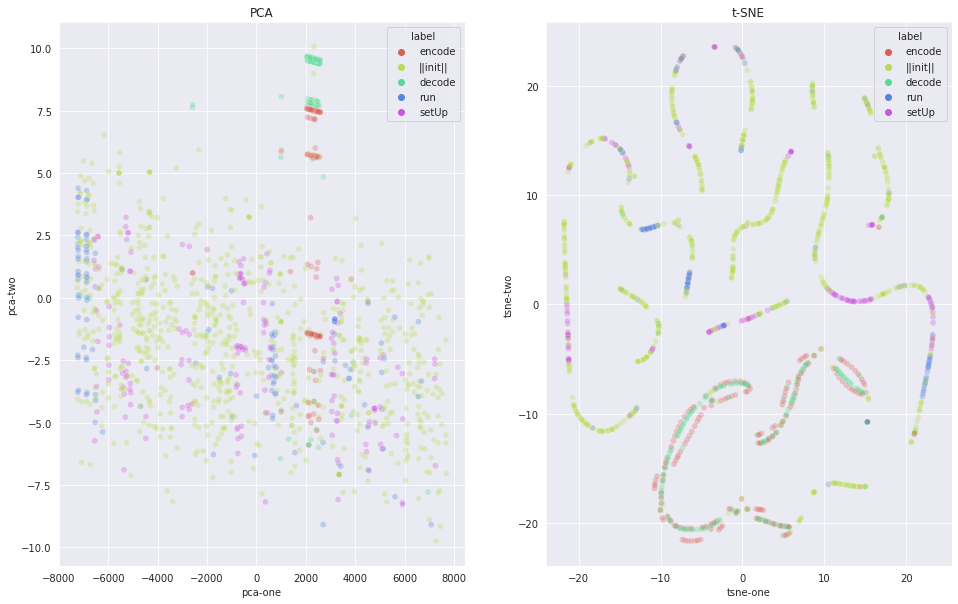

In [6]:
plt.figure(figsize=(16,10))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('PCA')
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", len(df_subset['label'].unique())),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)



ax2 = plt.subplot(1, 2, 2)
ax2.set_title('t-SNE')
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="label",
    palette=sns.color_palette("hls", len(df_subset['label'].unique())),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

# Clustering

Number of clusters: 5
Homogeneity: 0.234
Completeness: 0.203
V-measure: 0.218
Adjusted Rand Index: 0.045
Adjusted Mutual Information: 0.215
Silhouette Coefficient: 0.780


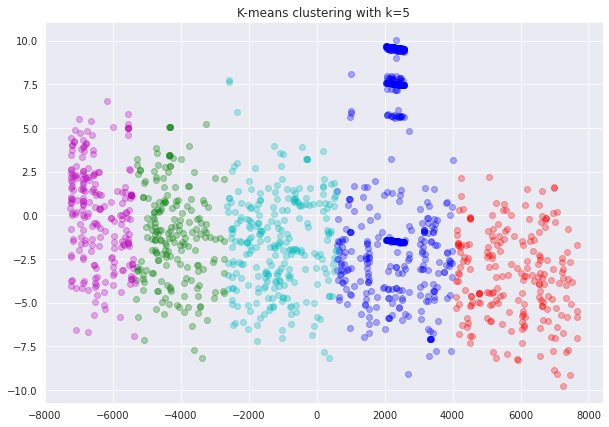

In [7]:
# Apply K-means
k=5
kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_result)

plt.figure(figsize=(10, 7))
plt.title(f'K-means clustering with k={k}')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = pca_result[kmeans.labels_ == klass]
    plt.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)
    
# print(data_subset['label'])
print('Number of clusters: %d' % k)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['label'], kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['label'], kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['label'], kmeans.labels_))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['label'], kmeans.labels_))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['label'], kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pca_result, kmeans.labels_, metric='sqeuclidean'))

In [12]:
# Apply OPTICS algorithm
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)
clust.fit(pca_result)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)


space = np.arange(len(pca_result))
reachability = clust.reachability_[clust.ordering_]
optics_labels = clust.labels_[clust.ordering_]

print('Number of clusters: %d' % len(clust.cluster_hierarchy_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['label'], optics_labels))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['label'], optics_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['label'], optics_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['label'], optics_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['label'], optics_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pca_result, optics_labels, metric='sqeuclidean'))

Number of clusters: 13
Homogeneity: 0.008
Completeness: 0.006
V-measure: 0.007
Adjusted Rand Index: -0.010
Adjusted Mutual Information: 0.001
Silhouette Coefficient: -0.148


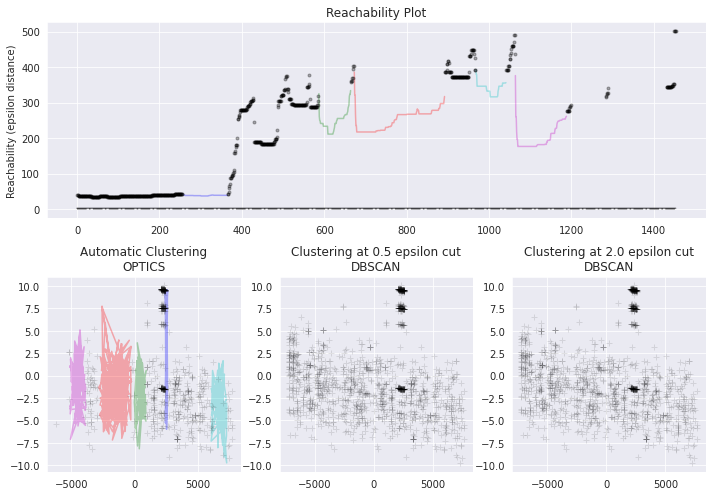

In [9]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, 5), colors):
    Xk = pca_result[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(pca_result[clust.labels_ == -1, 0], pca_result[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, 6), colors):
    Xk = pca_result[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(pca_result[labels_050 == -1, 0], pca_result[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, 4), colors):
    Xk = pca_result[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(pca_result[labels_200 == -1, 0], pca_result[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()